## 2. Model building

<br>

A **Bayesian statistical model** is specified by the **likelihood model** (also called observational model) and **prior model**. This can be expressed as the joint probability density of the data, $x$, and model parameters, $\theta$, such that
$$
p(x, \theta) = p(x | \theta) p(\theta).
$$

We perform inference by conditioning on the data and calculating expectation values of the resulting posterior distribution. Recalling **Bayes' theorem**
$$
p(\theta | x) = \frac{p(x | \theta)p(\theta)}{p(x)} \propto p(x, \theta),
$$
we note that the results of our inference are *completely dependent on the assumed model*. Bayes' theorem is not some magical guarantee, and if our model does not represent the actual *data generating process* our inference will yield results that are meaningless in practice. Even worse, if we are not careful, a misspecified model may produce results that "look good" but are far from the truth - leading us to draw the wrong conclusions from our analysis. 

<br>

Our workflow begins with building our first sensible model as a starting point, that we can later check and iterate upon to make sure our inferences are useful. The first model doesn't need to be perfect, and in fact should be as simple as possible while still including the scientific phenomenon of interest. This process is what we will focus on here.

<br>

### 2.1. Going from a scientific question to a statistical model

<br>

So, model building is very important, but where to start? It can be helpful to break down the problem into the following components:

* Scientific question
* Data
* Parameter(s) of interest
* Key nuisance parameter(s)
* Relevant domain expertise

The model-building problem then comes down to **defining a connection between your parameters and data** (the likelihood/observational model) and **incorporating relevant domain expertise** (the prior model). 

To get a feel for how this can work, consider the following examples:

<br>

<img src="figures/science_stats.pdf" alt="Going from a scientific question to a statistical model" width="750"/>

<br>

**Exercise 2.1:** Fill out this table for some more complicated examples such as
* What is the value of the Hubble constant?
* What is the mass of the Higgs boson?
Below are some relevant plots of data used to make such measurements.

The original Hubble diagram from [this paper](https://www.pnas.org/content/15/3/168):

<img src="figures/hubble.jpg" alt="The original Hubble diagram" width="600"/>

First presentation of ATLAS Higgs to $\gamma\gamma$ results on 4th July 2012:

<img src="figures/higgs.png" alt="https://atlas.cern/updates/feature/higgs-boson" width="500"/>

Can you add an example or two from your own field to this list?

### 2.2. The impossible model

<br>

When starting the model-building process, it can also be helpful to think about the ideal  model that you would fit if you had no restrictions on model complexity or computational resources. The purpose of this is to consider each step of the *data generating process* in detail, from start to finish. We are forced to think about complexities of the physical system and measurement process that may or may not be important for our later inference. The model itself may be impossible to actually write down or implement, but in doing this, we give can identify important steps and give context to the simpler models we will later go on to create. 

Taking the first example in the table above, consider what other effects may be important...

<br>

<img src="figures/ball_drop.pdf" alt="Thinking about more complete models" width="750"/>

<br>

**Exercise 2.2:** Can you expand the complexity for one of the other models that we discussed?

### 2.3. Probabilistic graphical models

<br>

For both of the above steps, it can be useful to sketch out connections between data and parameters using directed acyclic graphs (DAGs), often also called probabilistic graphical models (PGMs). These can be thought of as a visualisation of the data generating process, with parameters in unshaded circles, data or observations in shaded circles, and the arrows representing the connections between them. 

Here is a trivial example for that of data sampled from a normal distribution, such as what we looked at when introducing Stan in the *Are you ready?* section of the [introduction notebook](introduction.ipynb). The normal distribution is defined by two parameters, $\mu$ and $\sigma$. $N$ independent samples from this distribution are then taken, shown by $x_i$. The box around $x_i$ shows that there are a number of repeated samples, that we can think of as observations or measurements.

<br>

<img src="figures/simple_dag.pdf" alt="A simple DAG or PGM for normally-distributed data" width="200"/>

<br>

**Exercise 2.3:** Now it's your turn! Sketch graphical models for the first two examples in the above table (measurement of gravitational acceleration and radioactivity).

### 2.4. An example: the period-luminosity relation of Cepheid variable stars

<br>

Cepheid variables are a type of star that pulsates in observed flux, such that the apparent magnitude of the star varies in time with a well-defined period and amplitude. This behaviour is interesting in its own right, but also because it has been observed that there is a strong correlation between this period and the intrinsic luminosity of these stars. This **period-luminosity** relation has the form
$$
M = \alpha + \beta \log_{10} \bigg( \frac{P}{\mathrm{days}} \bigg), 
$$
where $M$ is the absolute magnitude, related to the apparent magnitude, $m$, by the luminosity distance, $d_L(z)$
$$
m = M + 5 \log_{10} \bigg( \frac{d_L(z)}{\mathrm{Mpc}} \bigg) + 25.
$$

<br>

<img src="figures/cepheid_intro.pdf" alt="Cepheid variables and the period-luminosity relation" width="600"/>

<br>

In astronomy, it is common to work with magnitudes instead of flux and luminosity, so the above expression is basically the equivalent of $F = L / 4 \pi d_L^2(z)$. The magnitude is related to the logarithm of flux/luminosity and it is important to remember that magnitude *decreases* with increasing brightness, although we typically invert the y-axis when plotting magnitude for easier interpretation. So, **intrinsically brighter Cepheids have longer periods**.

<br>

We know this because we can measure the distance to nearby Cepheids using *parallax*. By determining the period-luminosity relation, we can then measure the distance to Cepheids that are further away, extending the [cosmic distance ladder](https://en.wikipedia.org/wiki/Cosmic_distance_ladder). Measuring distances to far away objects allows us to compare their luminosity distance and redshift, giving us an estimate of the [Hubble constant](https://en.wikipedia.org/wiki/Hubble%27s_law). 

<br>

In the coming notebooks, we will explore a series of scientific questions related to Cepheid variable observations:

1. What is the nature of the period-luminosity relation?

2. Is the relationship universal? (i.e. the same in different galaxies)

3. What is the value of the Hubble constant?

### 2.5. Generative modelling

<br>

Using what we know about Cepheid variables and the period-luminosity relation, we can start to build a simple initial model for what we think could be the data-generating process. 

<br>

<u>Towards an initial model</u>

Measuring the period of a Cepheid is relatively straightforward from studying its lightcurve, and so to start with we can assume that the period is a known quantity. However, the observed characteristic apparent magnitude, $\hat{m}$, of a Cepheid can be more tricky to reconstruct exactly, so let's say that it is reported with some fixed uncertainty, $\sigma_m$, that is the same for all Cepheids. We can assume that 
$$
\hat{m} \sim \mathrm{Normal}(m, \sigma_m),
$$ 
where $m$ is the true apparent magnitude that is not observed. Knowing that our measured Cepheids are going to be pretty nearby ($z < 0.01$), we can approximate the luminosity distance as 
$$
d_L(z) = \frac{cz}{H_0},
$$
where $c$ is the speed of light, and $H_0$ is the Hubble constant. Again, for simplicity, let's assume that for now we just look at $N_c$ Cepheids in a single galaxy with a known redshift, $z$.

<br>

**Exercise 2.5.1:** With these simplifying assumptions in mind, sketch the corresponding graphical model for our initial Cepheid variable model. The parameters and known quantities are summarised below, just arrange them into a graph.

<br>

<img src="figures/cepheid_graph_bits.pdf" alt="Blobs for the simple Cepheid graphical model" width="750"/>

<br>

**Exercise 2.5.2:** Using the parameter and fixed quantity values given below, as well as your graphical model, write a simulation for the observed apparent magnitudes, $m_i$. Plot your results in $\log_{10}(P/\mathrm{days})$-$m$ space, comparing with the true period-luminosity relation. 



In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# known quantities
c = 3.0e5 # km/s
H0 = 70 # km/s/Mpc
z = 0.005

Nc = 10
P = [71.5, 45.0, 19.9, 30.6, 8.8, 75.2, 21.5, 22.0, 34.5, 87.4] # days
sigma_m = 0.5

# high-level parameter values
alpha = -2
beta = -4

In [3]:
# define some useful functions
def luminosity_distance(z):
    # To be completed...
    pass

def absolute_magnitude(m, z):
    # To be completed...
    pass

In [4]:
# simulate the observed apparent magnitudes
# M_true = ...
# m_true = ...
# m_obs = ...
# M_obs = ...
pass

No handles with labels found to put in legend.


Text(0, 0.5, 'm')

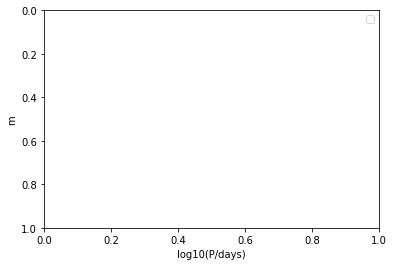

In [5]:
# plot the true and observed apparent magnitudes
log10_P_grid = np.linspace(0, 3)
fig, ax = plt.subplots()
#ax.scatter(log10_P, m_true, label="m_obs")
#ax.scatter(log10_P, m_obs, label="m_obs")
ax.invert_yaxis() # so brighter as y-axis increases
ax.legend()
ax.set_xlabel("log10(P/days)")
ax.set_ylabel("m")

No handles with labels found to put in legend.


Text(0, 0.5, 'M')

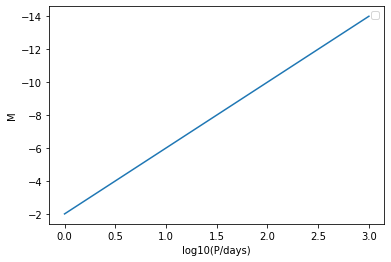

In [6]:
# plot the true and observed absolute magnitudes, compare with true P-L relation
log10_P_grid = np.linspace(0, 3)
fig, ax = plt.subplots()
#ax.scatter(log10_P, M_true, label="M_true")
#ax.scatter(log10_P, M_obs, label="M_obs")
ax.plot(log10_P_grid, alpha + beta * log10_P_grid)
ax.invert_yaxis() # so brighter as y-axis increases
ax.legend()
ax.set_xlabel("log10(P/days)")
ax.set_ylabel("M")

In the above plots, you may have been tempted to use `ax.errorbar()` or `plt.errorbar()` to show the data, `m` or `M` together with the uncertainty, `sigma_m`.

>Note: The uncertainties on `M` and `m` are equivalent, due to the additive relationship between the two.

This can be a helpful visualisation, and you are free to do so if you wish! However, it is important to remember that in the Bayesian way of thinking, data **do not** have errors, rather, **the model has uncertainty**. So the *observed* magnitude is not uncertain, we saw it! What is really uncertain is what it implies for the *true* magnitude, that we cannot see. 

To get a feel for this, let's re-run our simulation multiple times, and add the distribution of the true magnitudes to the above plot: 

No handles with labels found to put in legend.


Text(0, 0.5, 'M')

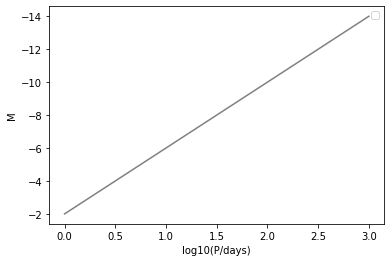

In [7]:
fig, ax = plt.subplots()
N_sims = 250
for i in range(N_sims):
    # to be completed...
    # run simulation
    # ax.scatter(log10_P, M_true, color="r", alpha=0.01)
    pass 
#ax.scatter(log10_P, M_obs, label="M_obs", color="g") # will not change per sim
ax.plot(log10_P_grid, alpha + beta * log10_P_grid, color="k", alpha=0.5)
ax.invert_yaxis() # so brighter as y-axis increases
ax.legend()
ax.set_xlabel("log10(P/days)")
ax.set_ylabel("M")

Now you should see a nice distribution of possible `M_true` values for each known `M_obs`. If we do want to plot errorbars, we can think of them as marking out the standard deviation of these `M_obs` distributions.

### 2.6. Exploratory data analysis

<br>

Now that we have some feeling for the generative model, let's take a look at some Cepheid variable data. You can find two files in the `data/` directory:
1. galaxies.dat 
2. cepheids.dat

The first contains information on the host galaxies, and the second contains information on the individual Cepheids studied in each host galaxy.

<br>

The right time in a workflow for exploratory data analysis can be difficult to define. In general, we want to be aware of how our data looks when designing a model for it, but also not too influenced such that we get carried away and design a model that *overfits* the data we have and is uncapable of generalising to unseen data. Here, we want to see how our first effort at a generative model stacks up, and also think about directions for improving our model.

**Exercise 2.6:** Complete the following exploratory data analysis.

In [8]:
# read in the files

# columns: gal z
galaxy_info = np.loadtxt("data/galaxies.dat")

# columns: gal m_obs sigma_m P[days] delta_logO_H
cepheid_info = np.loadtxt("data/cepheids.dat")

In [9]:
# reorganise the data into a dictionary indexed by the galaxy number
galaxies = [int(ngc_no) for ngc_no in galaxy_info[:, 0]]
data = {int(x[0]):{"z":x[1]} for x in galaxy_info}

for g in galaxies:
    j = np.where(cepheid_info[:, 0] == g)[0]
    data[g]["gal"] = np.array([int(i) for i in cepheid_info[j, 0]])
    data[g]["Nc"] = len(data[g]["gal"])
    data[g]["m_obs"] = cepheid_info[j, 1]
    data[g]["sigma_m"] = cepheid_info[j, 2]
    data[g]["P"] = cepheid_info[j, 3]
    data[g]["delta_logO_H"] = cepheid_info[j, 4]
    data[g]["log10P"] = np.log10(data[g]["P"])

In [10]:
# have a look at the data structure for the first galaxy
data[galaxies[0]]

{'z': 0.007125,
 'gal': array([1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309,
        1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309,
        1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309,
        1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309,
        1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309,
        1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309,
        1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309,
        1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309,
        1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309,
        1309, 1309, 1309, 1309, 1309]),
 'Nc': 104,
 'm_obs': array([24.81, 26.05, 26.04, 22.8 , 21.86, 23.45, 23.85, 25.68, 24.6 ,
        24.94, 21.34, 25.51, 23.45, 27.49, 24.16, 25.81, 23.9 , 26.28,
        22.47, 25.13, 26.4 , 23.37, 24.78, 24.04, 23.86, 23.36, 23.68,
        22.48, 22.99, 22.  , 26.91, 2

Let's plot the period vs. the apparent magnitude for a single galaxy. How does it compare to the simulated data?

Text(0, 0.5, 'm')

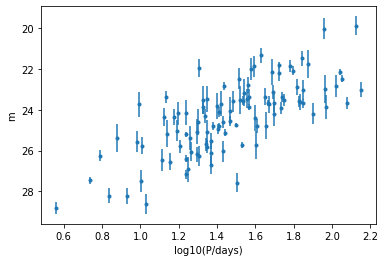

In [11]:
fig, ax = plt.subplots()
g = galaxies[0]
ax.errorbar(data[g]["log10P"], data[g]["m_obs"], yerr=data[g]["sigma_m"], fmt=".")
ax.invert_yaxis()
ax.set_xlabel("log10(P/days)")
ax.set_ylabel("m")

We can immediately see that here there are individual $\sigma_m$ for each Cepheid, and a somewhat visible linear relationship. Now for all the galaxies...

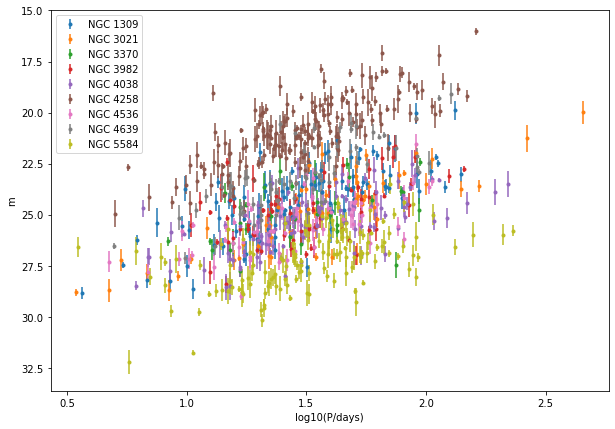

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 7))
for g in galaxies:
    ax.errorbar(data[g]["log10P"], data[g]["m_obs"], yerr=data[g]["sigma_m"], fmt=".",
                label="NGC %s" % g)
ax.invert_yaxis()
ax.set_xlabel("log10(P/days)")
ax.set_ylabel("m")
ax.legend()

We can see rough linear relationships for each galaxy, but not a universal one. To better assess this, we should convert to absolute magnitude.

In [13]:
# add absolute magnitude to the data
for g in galaxies:
    # to be completed...
    # data[g]["M_obs"] = absolute_magnitude(...)
    pass

No handles with labels found to put in legend.


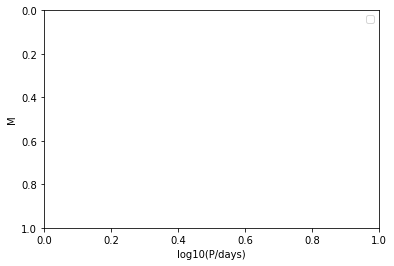

In [14]:
# plot for absolute magnitude this time 
fig, ax = plt.subplots()
for g in galaxies:
    # to be completed...
    pass
ax.invert_yaxis()
ax.set_xlabel("log10(P/days)")
ax.set_ylabel("M")
ax.legend()

We should now see a stronger global relation, but still with considerable intrinsic scatter and potential differences between galaxies. 

<br>

We can see other quantities in the provided files, such as a measure of the metallicity of each star, `log(O/H)`. What do the distributions of `log(O/H)` look like for different galaxies? Is there any relationship between `log(O/H)` and `M_obs`?

In [15]:
# to be completed...

How about the distributions of `P` in different galaxies? Why are some values of `P` more frequently observed than others?

In [16]:
# to be completed...

In light of the data, what are some ways in which we may want to expand our model one day??

In [17]:
# to be completed... make some bullet points

### Further reading

The dataset prepared for this course is based on that reported in [Reiss et al. 2011](https://iopscience.iop.org/article/10.1088/0004-637X/730/2/119).